In [1]:
import torch
import sys
sys.path.append("..")
from src.sd3_pipeline import VSFStableDiffusion3Pipeline
import json
import judge
import wandb
import numpy as np
import dotenv
dotenv.load_dotenv()
import argparse

model_id = "stabilityai/stable-diffusion-3.5-large-turbo"
pipe = VSFStableDiffusion3Pipeline.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


VSFStableDiffusion3Pipeline {
  "_class_name": "VSFStableDiffusion3Pipeline",
  "_diffusers_version": "0.35.0.dev0",
  "_name_or_path": "stabilityai/stable-diffusion-3.5-large-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_3": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_3": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "SD3Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [53]:
image_norm = pipe(
    "A rainy day scene in a Japanese city, people walking with umbrellas on a narrow street lined with convenience stores and vending machines, reflections on wet pavement, soft light from shop signs and street lamps, distant misty buildings, in detailed Japanese anime style, atmospheric and cinematic.",
    negative_prompt="umbrellas",
    guidance_scale=0.,
    scale=0,
    offset=0.1,
    num_inference_steps=8,
    generator=torch.Generator("cuda").manual_seed(42),
).images[0]

  0%|          | 0/8 [00:00<?, ?it/s]

In [54]:
image = pipe(
    "A rainy day scene in a Japanese city, people walking with umbrellas on a narrow street lined with convenience stores and vending machines, reflections on wet pavement, soft light from shop signs and street lamps, distant misty buildings, in detailed Japanese anime style, atmospheric and cinematic.",
    negative_prompt="umbrellas",
    guidance_scale=0.,
    scale=3,
    offset=0.1,
    num_inference_steps=8,
    generator=torch.Generator("cuda").manual_seed(42),
).images[0]

  0%|          | 0/8 [00:00<?, ?it/s]

In [55]:
pos_maps = torch.stack(torch.stack([i[0] for i in pipe.maps]).chunk(8, 0)).mean(1).sum(-1).mean(2).reshape((8, 64, 64))
neg_maps = torch.stack(torch.stack([i[1] for i in pipe.maps]).chunk(8, 0)).mean(1).sum(-1).mean(2).reshape((8, 64, 64))

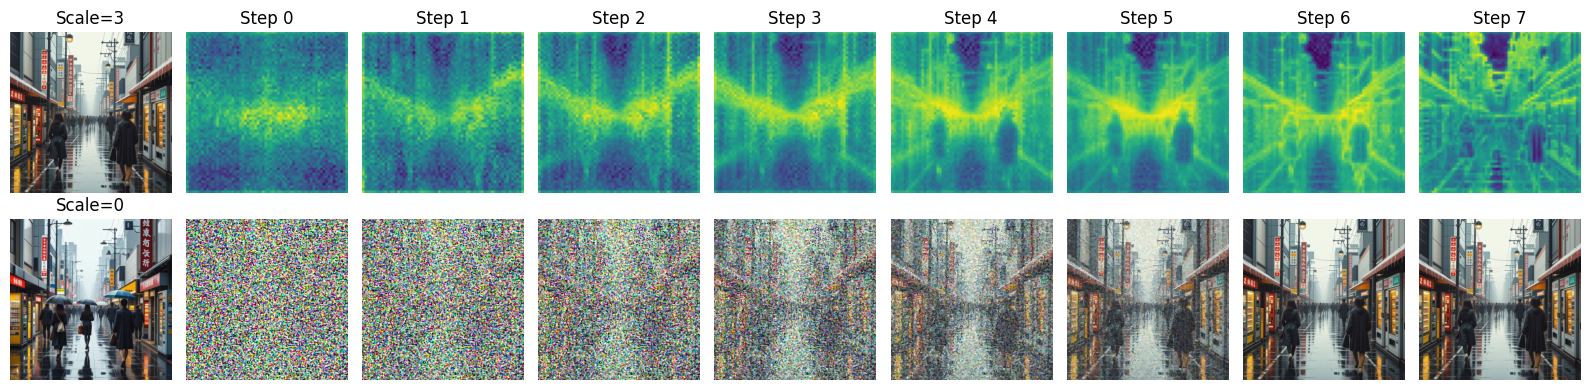

In [56]:
import pylab
frame_idx = 4
pylab.figure(figsize=(16, 4))
pylab.subplot(2, 9, 1)
pylab.imshow(image)
pylab.title("Scale=3")
pylab.axis("off")
pylab.subplot(2, 9, 10)
pylab.imshow(image_norm)
pylab.title("Scale=0")
pylab.axis("off")

for i in range(8):
    pylab.subplot(2, 9, i + 1 + 1)
    pylab.imshow(neg_maps[i].float().numpy()) 
    pylab.title("Step %d" % (i))
    pylab.axis("off")
    pylab.subplot(2, 9, i + 9 + 2)
    pylab.imshow(pipe.images[i][0])
    pylab.axis("off")
pylab.tight_layout()
pylab.savefig("attn_map.png", dpi=600)

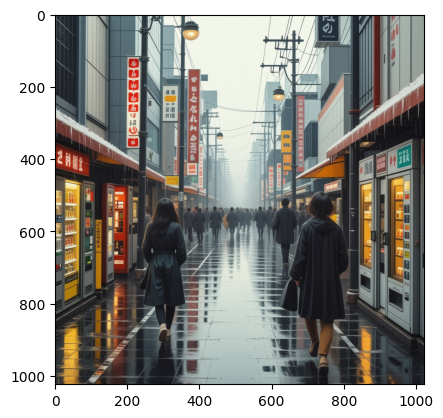

In [57]:
pylab.imshow(pipe.images[7][0])

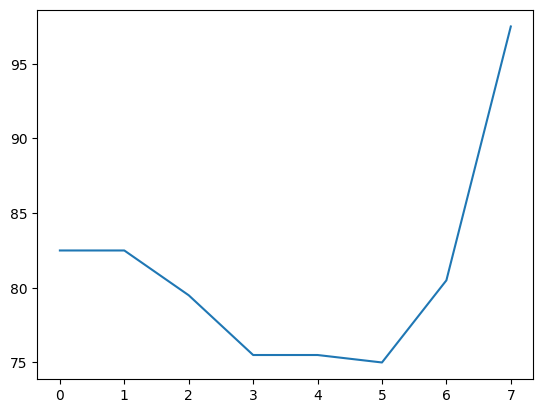

In [58]:
pylab.plot(neg_maps.mean((1,2)).float().numpy())